In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import random_split, DataLoader

# افزایش داده و نرمال سازی

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),

    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.44080), (0.2675, 0.2568, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.44080), (0.2675, 0.2568, 0.2761))
])

# بارگزاری داده ها

In [10]:
trainval_data = CIFAR100(root='./data', train=True, download=True,
                                              transform=transform_train)
test_data = CIFAR100(root='./data', train=False, download=True,
                      transform=transform_train)

100%|██████████| 169001437/169001437 [08:10<00:00, 344331.51it/s] 


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# تقسیم داده به آموزش و اعتبار سنجی

In [11]:
train_size = int(0.6 * len(trainval_data))
val_size = len(trainval_data) - train_size
train_data, val_data = random_split(trainval_data, [train_size, val_size])


In [17]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# ساخت مدل CNN 

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# آموزش مدل

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #L2 regularization
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

l1_lambda = 1e-5  # L1

train_losses, val_losses = [], []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # ارزیابی روی داده اعتبارسنجی
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1: Train Loss: 4.1000, Val Loss: 3.7096
Epoch 2: Train Loss: 3.6855, Val Loss: 3.4516
Epoch 3: Train Loss: 3.5061, Val Loss: 3.2656
Epoch 4: Train Loss: 3.3504, Val Loss: 3.1785
Epoch 5: Train Loss: 3.2376, Val Loss: 3.0817
Epoch 6: Train Loss: 3.1302, Val Loss: 2.8481
Epoch 7: Train Loss: 3.0355, Val Loss: 2.9325
Epoch 8: Train Loss: 2.9654, Val Loss: 2.7692
Epoch 9: Train Loss: 2.8929, Val Loss: 2.6542
Epoch 10: Train Loss: 2.8428, Val Loss: 2.6290
Epoch 11: Train Loss: 2.7895, Val Loss: 2.5754
Epoch 12: Train Loss: 2.7451, Val Loss: 2.6184
Epoch 13: Train Loss: 2.6915, Val Loss: 2.4788
Epoch 14: Train Loss: 2.6458, Val Loss: 2.4626
Epoch 15: Train Loss: 2.6156, Val Loss: 2.3859
Epoch 16: Train Loss: 2.5568, Val Loss: 2.4623
Epoch 17: Train Loss: 2.5358, Val Loss: 2.3812
Epoch 18: Train Loss: 2.4963, Val Loss: 2.3272
Epoch 19: Train Loss: 2.4630, Val Loss: 2.3897
Epoch 20: Train Loss: 2.4405, Val Loss: 2.2669


# ارزیابی مدل

              precision    recall  f1-score   support

           0     0.6182    0.6800    0.6476       100
           1     0.4315    0.6300    0.5122       100
           2     0.2870    0.3300    0.3070       100
           3     0.2615    0.1700    0.2061       100
           4     0.1376    0.1500    0.1435       100
           5     0.3120    0.3900    0.3467       100
           6     0.3519    0.5700    0.4351       100
           7     0.4714    0.3300    0.3882       100
           8     0.5100    0.5100    0.5100       100
           9     0.7045    0.3100    0.4306       100
          10     0.3014    0.2200    0.2543       100
          11     0.2987    0.2300    0.2599       100
          12     0.4483    0.5200    0.4815       100
          13     0.3944    0.2800    0.3275       100
          14     0.2909    0.1600    0.2065       100
          15     0.3049    0.2500    0.2747       100
          16     0.5065    0.3900    0.4407       100
          17     0.5818    

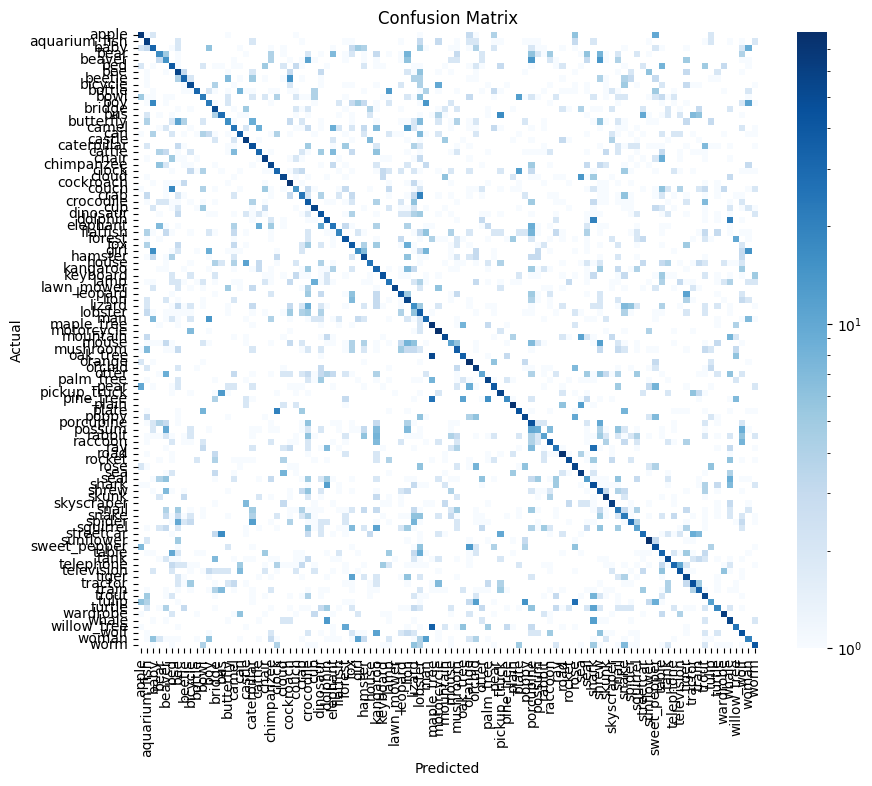

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# پیش‌بینی روی داده تست
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# متریک‌ها
print(classification_report(all_labels, all_preds, digits=4))

# ماتریس درهم‌ریختگی
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=test_data.classes, yticklabels=test_data.classes, cmap='Blues', norm='log')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [28]:
from torchvision import models

model_tl = models.resnet50(pretrained=True)
model_tl.fc = nn.Linear(model_tl.fc.in_features, 100)  # تطبیق با 100 کلاس

model_tl = model_tl.to(device)

optimizer = optim.Adam(model_tl.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# می‌توان لایه‌های اولیه را Freeze و فقط لایه‌های بالا را آموزش داد:
for param in model_tl.parameters():
    param.requires_grad = False
for param in model_tl.fc.parameters():
    param.requires_grad = True

c:\Users\Reza\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Reza\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Reza/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
  3%|▎         | 2.88M/97.8M [01:36<53:13, 31.2kB/s]  


KeyboardInterrupt: 

In [ ]:
# نمایش 10 تصویر اشتباه پیش‌بینی‌شده
import matplotlib.pyplot as plt

misclassified = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((inputs[i].cpu(), preds[i].item(), labels[i].item()))
        if len(misclassified) >= 10:
            break

# نمایش تصاویر
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, (img, pred, true) in enumerate(misclassified[:10]):
    img = img.permute(1, 2, 0).numpy()
    img = (img * 0.2761 + 0.4408).clip(0, 1)  # denormalize
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"Pred: {pred}, True: {true}")
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()